In [1]:
import pyodbc
import pandas as pd
import swifter
import seaborn as sns
import gc
import matplotlib.pyplot as plt
from tune_sklearn import TuneGridSearchCV, TuneSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.impute import SimpleImputer
import numpy as np
import evalml
import swifter
gc.collect()

1189

In [2]:
def preproc_data(df):
    df.iloc[:, 2:-3] = df.iloc[:, 2:-3].fillna(0)
    df.online_purch_flg = df.online_purch_flg.map({False:0, True:1})
    df.sex = df.sex.fillna(0)
    df.age = df.age.fillna(35)
    return df
    

# Load Data

In [3]:
with pyodbc.connect('DRIVER={SQL SERVER};SERVER=SAS-CI-DB1-P') as conn:
    strq = 'SELECT DISTINCT phone\
                    , CommFlag\
                    , OrderFlag\
                    ,Order_Ago\
                    ,min_diff\
                   , max_diff\
                    ,avg_diff\
                    ,avg_check\
                    ,offline_Order_Ago\
                    ,min_offline_diff\
                    ,max_offline_diff\
                    ,avg_offline_diff\
                    ,avg_offline_check\
                    ,online_Order_Ago\
                    ,min_online_diff\
                    ,max_online_diff\
                    ,avg_online_diff\
                    ,avg_online_check\
                    ,sum_amount_3\
                    ,sum_amount_6\
                    ,sum_amount_9\
                    ,sum_amount_12\
                    ,sum_amount_15\
                    ,sum_amount_18\
                    ,cnt_amount_3\
                    ,cnt_amount_6\
                    ,cnt_amount_9\
                    ,cnt_amount_12\
                    ,cnt_amount_15\
                    ,cnt_amount_18\
                    ,sum_offline_amount_3\
                    ,sum_offline_amount_6\
                    ,sum_offline_amount_9\
                    ,sum_offline_amount_12\
                    ,sum_offline_amount_15\
                    ,sum_offline_amount_18\
                    ,cnt_offline_amount_3\
                    ,cnt_offline_amount_6\
                    ,cnt_offline_amount_9\
                    ,cnt_offline_amount_12\
                    ,cnt_offline_amount_15\
                    ,cnt_offline_amount_18\
                    ,sum_online_amount_3\
                    ,sum_online_amount_6\
                    ,sum_online_amount_9\
                    ,sum_online_amount_12\
                    ,sum_online_amount_15\
                    ,sum_online_amount_18\
                    ,cnt_online_amount_3\
                    ,cnt_online_amount_6\
                    ,cnt_online_amount_9\
                    ,cnt_online_amount_12\
                    ,cnt_online_amount_15\
                    ,cnt_online_amount_18\
                    ,online_purch_flg\
                    , age\
                    , LIFECYCLE_TYPE\
                    , sex \
                    FROM ##DataTrain\
                    WHERE cnt_amount_18 > 0'
    df = pd.read_sql(strq, conn)

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


In [4]:
df.dtypes

phone                     object
CommFlag                   int64
OrderFlag                  int64
Order_Ago                  int64
min_diff                 float64
max_diff                 float64
avg_diff                 float64
avg_check                float64
offline_Order_Ago        float64
min_offline_diff         float64
max_offline_diff         float64
avg_offline_diff         float64
avg_offline_check        float64
online_Order_Ago         float64
min_online_diff          float64
max_online_diff          float64
avg_online_diff          float64
avg_online_check         float64
sum_amount_3             float64
sum_amount_6             float64
sum_amount_9             float64
sum_amount_12            float64
sum_amount_15            float64
sum_amount_18            float64
cnt_amount_3               int64
cnt_amount_6               int64
cnt_amount_9               int64
cnt_amount_12              int64
cnt_amount_15              int64
cnt_amount_18              int64
sum_offlin

In [5]:
df.head()

,phone,CommFlag,OrderFlag,Order_Ago,min_diff,max_diff,avg_diff,avg_check,offline_Order_Ago,min_offline_diff,...,cnt_online_amount_3,cnt_online_amount_6,cnt_online_amount_9,cnt_online_amount_12,cnt_online_amount_15,cnt_online_amount_18,online_purch_flg,age,LIFECYCLE_TYPE,sex
0,70000020494,0,1,1,4.0,256.0,49.0,3402.4222,1.0,4.0,...,8,9,10,10,10,13,True,NaN,1,0.0
1,70000068068,0,0,10,NaN,NaN,NaN,1844.0000,NaN,NaN,...,0,0,0,1,1,1,True,47.0,1,0.0
2,70000069087,0,0,4,8.0,82.0,48.0,9827.7000,4.0,8.0,...,0,0,0,1,1,1,True,35.0,1,0.0
3,70000103922,0,0,1,1.0,98.0,27.0,3437.3096,3.0,1.0,...,1,1,1,1,1,1,True,33.0,1,0.0
4,70000146945,0,0,5,1.0,171.0,44.0,4742.9785,5.0,36.0,...,0,0,0,0,0,9,True,21.0,1,0.0


In [6]:
# med = df.age.median()
# df.age = df.age.swifter.apply(lambda x: x if (x > 16) and (x < 80) else med)
# df.age = df.age.fillna(med)
# df.sex = df.sex.fillna(round(df.sex.median()))
# df.Order_Ago = df.Order_Ago.fillna(36)


In [7]:
df.head()

,phone,CommFlag,OrderFlag,Order_Ago,min_diff,max_diff,avg_diff,avg_check,offline_Order_Ago,min_offline_diff,...,cnt_online_amount_3,cnt_online_amount_6,cnt_online_amount_9,cnt_online_amount_12,cnt_online_amount_15,cnt_online_amount_18,online_purch_flg,age,LIFECYCLE_TYPE,sex
0,70000020494,0,1,1,4.0,256.0,49.0,3402.4222,1.0,4.0,...,8,9,10,10,10,13,True,NaN,1,0.0
1,70000068068,0,0,10,NaN,NaN,NaN,1844.0000,NaN,NaN,...,0,0,0,1,1,1,True,47.0,1,0.0
2,70000069087,0,0,4,8.0,82.0,48.0,9827.7000,4.0,8.0,...,0,0,0,1,1,1,True,35.0,1,0.0
3,70000103922,0,0,1,1.0,98.0,27.0,3437.3096,3.0,1.0,...,1,1,1,1,1,1,True,33.0,1,0.0
4,70000146945,0,0,5,1.0,171.0,44.0,4742.9785,5.0,36.0,...,0,0,0,0,0,9,True,21.0,1,0.0


In [8]:
df.describe()

,CommFlag,OrderFlag,Order_Ago,min_diff,max_diff,avg_diff,avg_check,offline_Order_Ago,min_offline_diff,max_offline_diff,...,sum_online_amount_18,cnt_online_amount_3,cnt_online_amount_6,cnt_online_amount_9,cnt_online_amount_12,cnt_online_amount_15,cnt_online_amount_18,age,LIFECYCLE_TYPE,sex
count,7.310018e+06,7.310018e+06,7.310018e+06,4.477311e+06,4.477311e+06,4.477311e+06,7.310018e+06,6.695041e+06,4.115188e+06,4.115188e+06,...,1.260434e+06,7.310018e+06,7.310018e+06,7.310018e+06,7.310018e+06,7.310018e+06,7.310018e+06,6.112303e+06,7.310018e+06,6.909262e+06
mean,8.315423e-01,2.152717e-02,5.975048e+00,7.658973e+01,1.662730e+02,1.143255e+02,2.710004e+03,6.131818e+00,7.745095e+01,1.649482e+02,...,5.908934e+03,7.093293e-02,1.101331e-01,1.685170e-01,2.419251e-01,2.862332e-01,3.284810e-01,3.971211e+01,9.805717e-01,1.374258e-01
std,3.742723e-01,1.451336e-01,4.321633e+00,1.025610e+02,1.025161e+02,9.241288e+01,3.242469e+03,4.366500e+00,1.021542e+02,1.022047e+02,...,4.382892e+04,5.781092e-01,1.088324e+00,1.331768e+00,1.665111e+00,1.973524e+00,2.054090e+00,1.230264e+01,1.380247e-01,3.442964e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-6.621741e+05,0.000000e+00,0.000000e+00,0.000000e+00,...,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.300000e+01,0.000000e+00,0.000000e+00
25%,1.000000e+00,0.000000e+00,2.000000e+00,7.000000e+00,9.200000e+01,5.100000e+01,1.127000e+03,2.000000e+00,7.000000e+00,9.100000e+01,...,2.073000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.100000e+01,1.000000e+00,0.000000e+00
50%,1.000000e+00,0.000000e+00,5.000000e+00,3.100000e+01,1.530000e+02,8.800000e+01,2.163225e+03,5.000000e+00,3.300000e+01,1.510000e+02,...,3.704000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.800000e+01,1.000000e+00,0.000000e+00
75%,1.000000e+00,0.000000e+00,9.000000e+00,1.050000e+02,2.270000e+02,1.500000e+02,3.569400e+03,1.000000e+01,1.070000e+02,2.260000e+02,...,6.465000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.800000e+01,1.000000e+00,0.000000e+00
max,1.000000e+00,1.000000e+00,1.800000e+01,5.480000e+02,5.480000e+02,5.480000e+02,3.200000e+06,1.800000e+01,5.480000e+02,5.480000e+02,...,2.986616e+07,6.390000e+02,1.345000e+03,1.743000e+03,2.075000e+03,2.445000e+03,2.445000e+03,9.300000e+01,1.000000e+00,1.000000e+00


In [9]:
df.to_csv('DataSetUpLif.csv', index = False, sep = ';')

In [10]:
#print('Median age ', med)

In [11]:
del df

In [2]:
with pyodbc.connect('DRIVER={SQL SERVER};SERVER=SAS-CI-DB1-P') as conn:
    strq = 'SELECT * FROM ##Segs'
    segs = pd.read_sql(strq, conn)
display(segs.head())
print(segs.shape)

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


,SEGMENT_N,MOBILE
0,7,79263601250
1,1,79262037864
2,1,79268635216
3,5,79139225553
4,6,79233000608


(19280083, 2)


In [3]:
segs.to_csv('segments.csv', index = False)

# EDA

In [3]:
df = pd.read_csv('DataSetUpLif.zip', sep = ';', dtype={'phone':'str'})#.merge(pd.read_csv('segments.zip', dtype= {'MOBILE':'str', 'SEGMENT_N':'int'}), left_on='phone', right_on='MOBILE').query('SEGMENT_N > 3').drop(['SEGMENT_N'
                                                                       #                                                                                                     , 'MOBILE']
                                                                      #                                                                                                    , axis = 1)

In [4]:
display(df.head())
print(df.dtypes)
print(df.shape)

,phone,CommFlag,OrderFlag,Order_Ago,min_diff,max_diff,avg_diff,avg_check,offline_Order_Ago,min_offline_diff,...,cnt_online_amount_3,cnt_online_amount_6,cnt_online_amount_9,cnt_online_amount_12,cnt_online_amount_15,cnt_online_amount_18,online_purch_flg,age,LIFECYCLE_TYPE,sex
0,70000136255,1,0,5,3.0,9.0,6.0,2637.8888,NaN,NaN,...,0,9,9,9,9,9,True,24.0,0,0.0
1,70501081555,1,0,0,7.0,141.0,55.0,5817.5720,0.0,7.0,...,0,0,0,0,0,0,False,37.0,1,0.0
2,70501521555,1,0,4,1.0,402.0,201.0,6115.9000,4.0,1.0,...,0,1,1,1,1,1,True,35.0,1,0.0
3,70501655539,1,0,1,21.0,158.0,79.0,1544.5166,1.0,21.0,...,0,0,0,0,0,0,False,36.0,1,0.0
4,70501785797,1,0,1,6.0,138.0,45.0,4680.2807,1.0,6.0,...,0,0,0,0,0,0,False,43.0,1,0.0


phone                     object
CommFlag                   int64
OrderFlag                  int64
Order_Ago                  int64
min_diff                 float64
max_diff                 float64
avg_diff                 float64
avg_check                float64
offline_Order_Ago        float64
min_offline_diff         float64
max_offline_diff         float64
avg_offline_diff         float64
avg_offline_check        float64
online_Order_Ago         float64
min_online_diff          float64
max_online_diff          float64
avg_online_diff          float64
avg_online_check         float64
sum_amount_3             float64
sum_amount_6             float64
sum_amount_9             float64
sum_amount_12            float64
sum_amount_15            float64
sum_amount_18            float64
cnt_amount_3               int64
cnt_amount_6               int64
cnt_amount_9               int64
cnt_amount_12              int64
cnt_amount_15              int64
cnt_amount_18              int64
sum_offlin

In [5]:
df = df.set_index('phone')
df.head()

,CommFlag,OrderFlag,Order_Ago,min_diff,max_diff,avg_diff,avg_check,offline_Order_Ago,min_offline_diff,max_offline_diff,...,cnt_online_amount_3,cnt_online_amount_6,cnt_online_amount_9,cnt_online_amount_12,cnt_online_amount_15,cnt_online_amount_18,online_purch_flg,age,LIFECYCLE_TYPE,sex
phone,,,,,,,,,,,,,,,,,,,,,
70000136255,1,0,5,3.0,9.0,6.0,2637.8888,NaN,NaN,NaN,...,0,9,9,9,9,9,True,24.0,0,0.0
70501081555,1,0,0,7.0,141.0,55.0,5817.5720,0.0,7.0,141.0,...,0,0,0,0,0,0,False,37.0,1,0.0
70501521555,1,0,4,1.0,402.0,201.0,6115.9000,4.0,1.0,402.0,...,0,1,1,1,1,1,True,35.0,1,0.0
70501655539,1,0,1,21.0,158.0,79.0,1544.5166,1.0,21.0,158.0,...,0,0,0,0,0,0,False,36.0,1,0.0
70501785797,1,0,1,6.0,138.0,45.0,4680.2807,1.0,6.0,138.0,...,0,0,0,0,0,0,False,43.0,1,0.0


In [6]:
any(df.isna())

True

In [7]:
df = preproc_data(df)


In [8]:
colls = df.columns.tolist()
for coll in colls:
    if any(df[coll].isna()):
        print(coll)

In [9]:
df.iloc[:, 3:-3].head()

,min_diff,max_diff,avg_diff,avg_check,offline_Order_Ago,min_offline_diff,max_offline_diff,avg_offline_diff,avg_offline_check,online_Order_Ago,...,sum_online_amount_12,sum_online_amount_15,sum_online_amount_18,cnt_online_amount_3,cnt_online_amount_6,cnt_online_amount_9,cnt_online_amount_12,cnt_online_amount_15,cnt_online_amount_18,online_purch_flg
phone,,,,,,,,,,,,,,,,,,,,,
70000136255,3.0,9.0,6.0,2637.8888,0.0,0.0,0.0,0.0,0.0000,5.0,...,23741.0,23741.0,23741.0,0,9,9,9,9,9,1
70501081555,7.0,141.0,55.0,5817.5720,0.0,7.0,141.0,55.0,5817.5720,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
70501521555,1.0,402.0,201.0,6115.9000,4.0,1.0,402.0,201.0,7244.8750,4.0,...,1600.0,1600.0,1600.0,0,1,1,1,1,1,1
70501655539,21.0,158.0,79.0,1544.5166,1.0,21.0,158.0,79.0,1544.5166,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
70501785797,6.0,138.0,45.0,4680.2807,1.0,6.0,138.0,45.0,4680.2807,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


In [10]:
df.head()

,CommFlag,OrderFlag,Order_Ago,min_diff,max_diff,avg_diff,avg_check,offline_Order_Ago,min_offline_diff,max_offline_diff,...,cnt_online_amount_3,cnt_online_amount_6,cnt_online_amount_9,cnt_online_amount_12,cnt_online_amount_15,cnt_online_amount_18,online_purch_flg,age,LIFECYCLE_TYPE,sex
phone,,,,,,,,,,,,,,,,,,,,,
70000136255,1,0,5,3.0,9.0,6.0,2637.8888,0.0,0.0,0.0,...,0,9,9,9,9,9,1,24.0,0,0.0
70501081555,1,0,0,7.0,141.0,55.0,5817.5720,0.0,7.0,141.0,...,0,0,0,0,0,0,0,37.0,1,0.0
70501521555,1,0,4,1.0,402.0,201.0,6115.9000,4.0,1.0,402.0,...,0,1,1,1,1,1,1,35.0,1,0.0
70501655539,1,0,1,21.0,158.0,79.0,1544.5166,1.0,21.0,158.0,...,0,0,0,0,0,0,0,36.0,1,0.0
70501785797,1,0,1,6.0,138.0,45.0,4680.2807,1.0,6.0,138.0,...,0,0,0,0,0,0,0,43.0,1,0.0


In [11]:
m = df.iloc[:, 2:].mean()
sig = df.iloc[:, 2:].std()
df.iloc[:, 2:] = (df.iloc[:, 2:] - m) / (sig + 1e-12)

In [12]:
np.save('means.npy', m.values)
np.save('std.npy', sig.values)

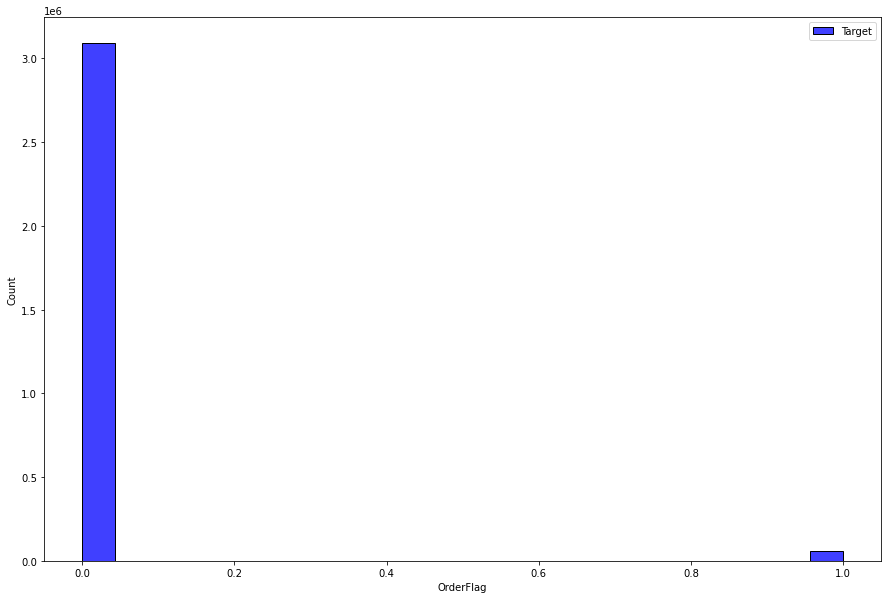

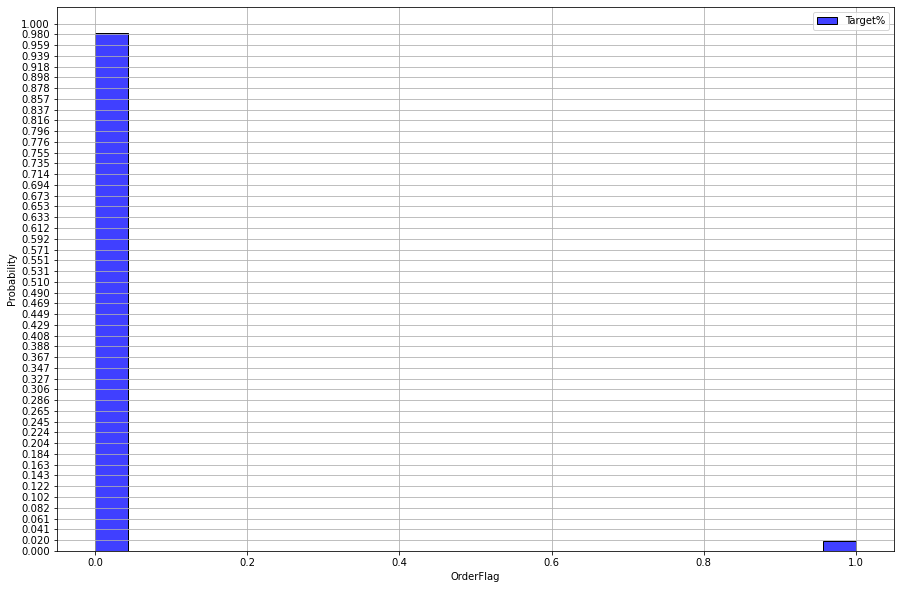

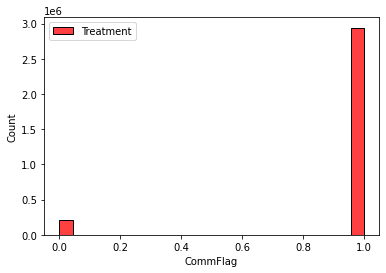

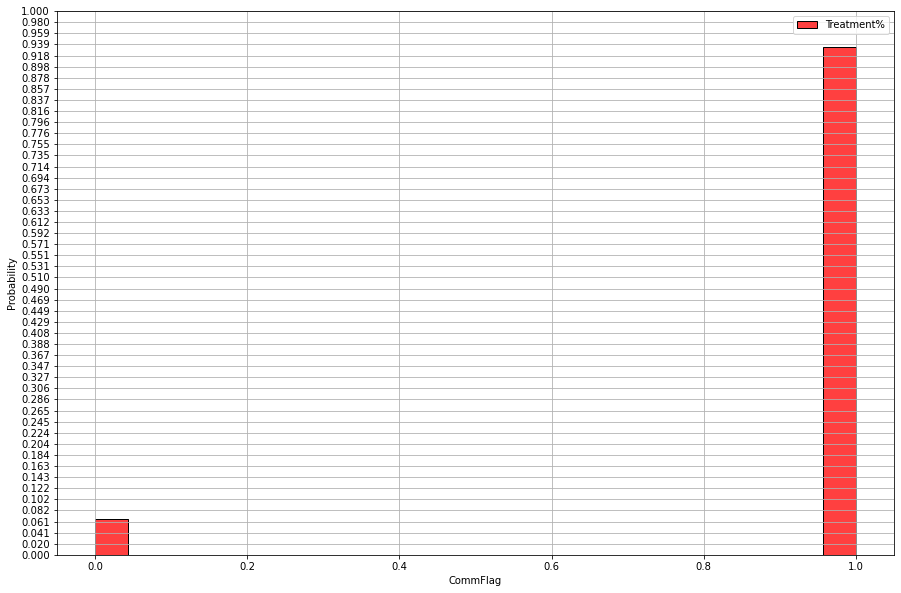

In [13]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (15, 10))
sns.histplot(df.OrderFlag, label = 'Target', color = 'blue')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize = (15, 10))
sns.histplot(df.OrderFlag, label = 'Target%', color = 'blue', stat = 'probability')
ax.set_yticks(np.linspace(0, 1, 50))
ax.grid('both')
plt.legend()
plt.show()

sns.histplot(df.CommFlag, label = 'Treatment', color = 'red')
plt.legend()
plt.show()


fig, ax = plt.subplots(figsize = (15, 10))
sns.histplot(df.CommFlag, label = 'Treatment%', color = 'red', stat = 'probability')
ax.set_yticks(np.linspace(0, 1, 50))
ax.grid('both')
plt.legend()
plt.show()

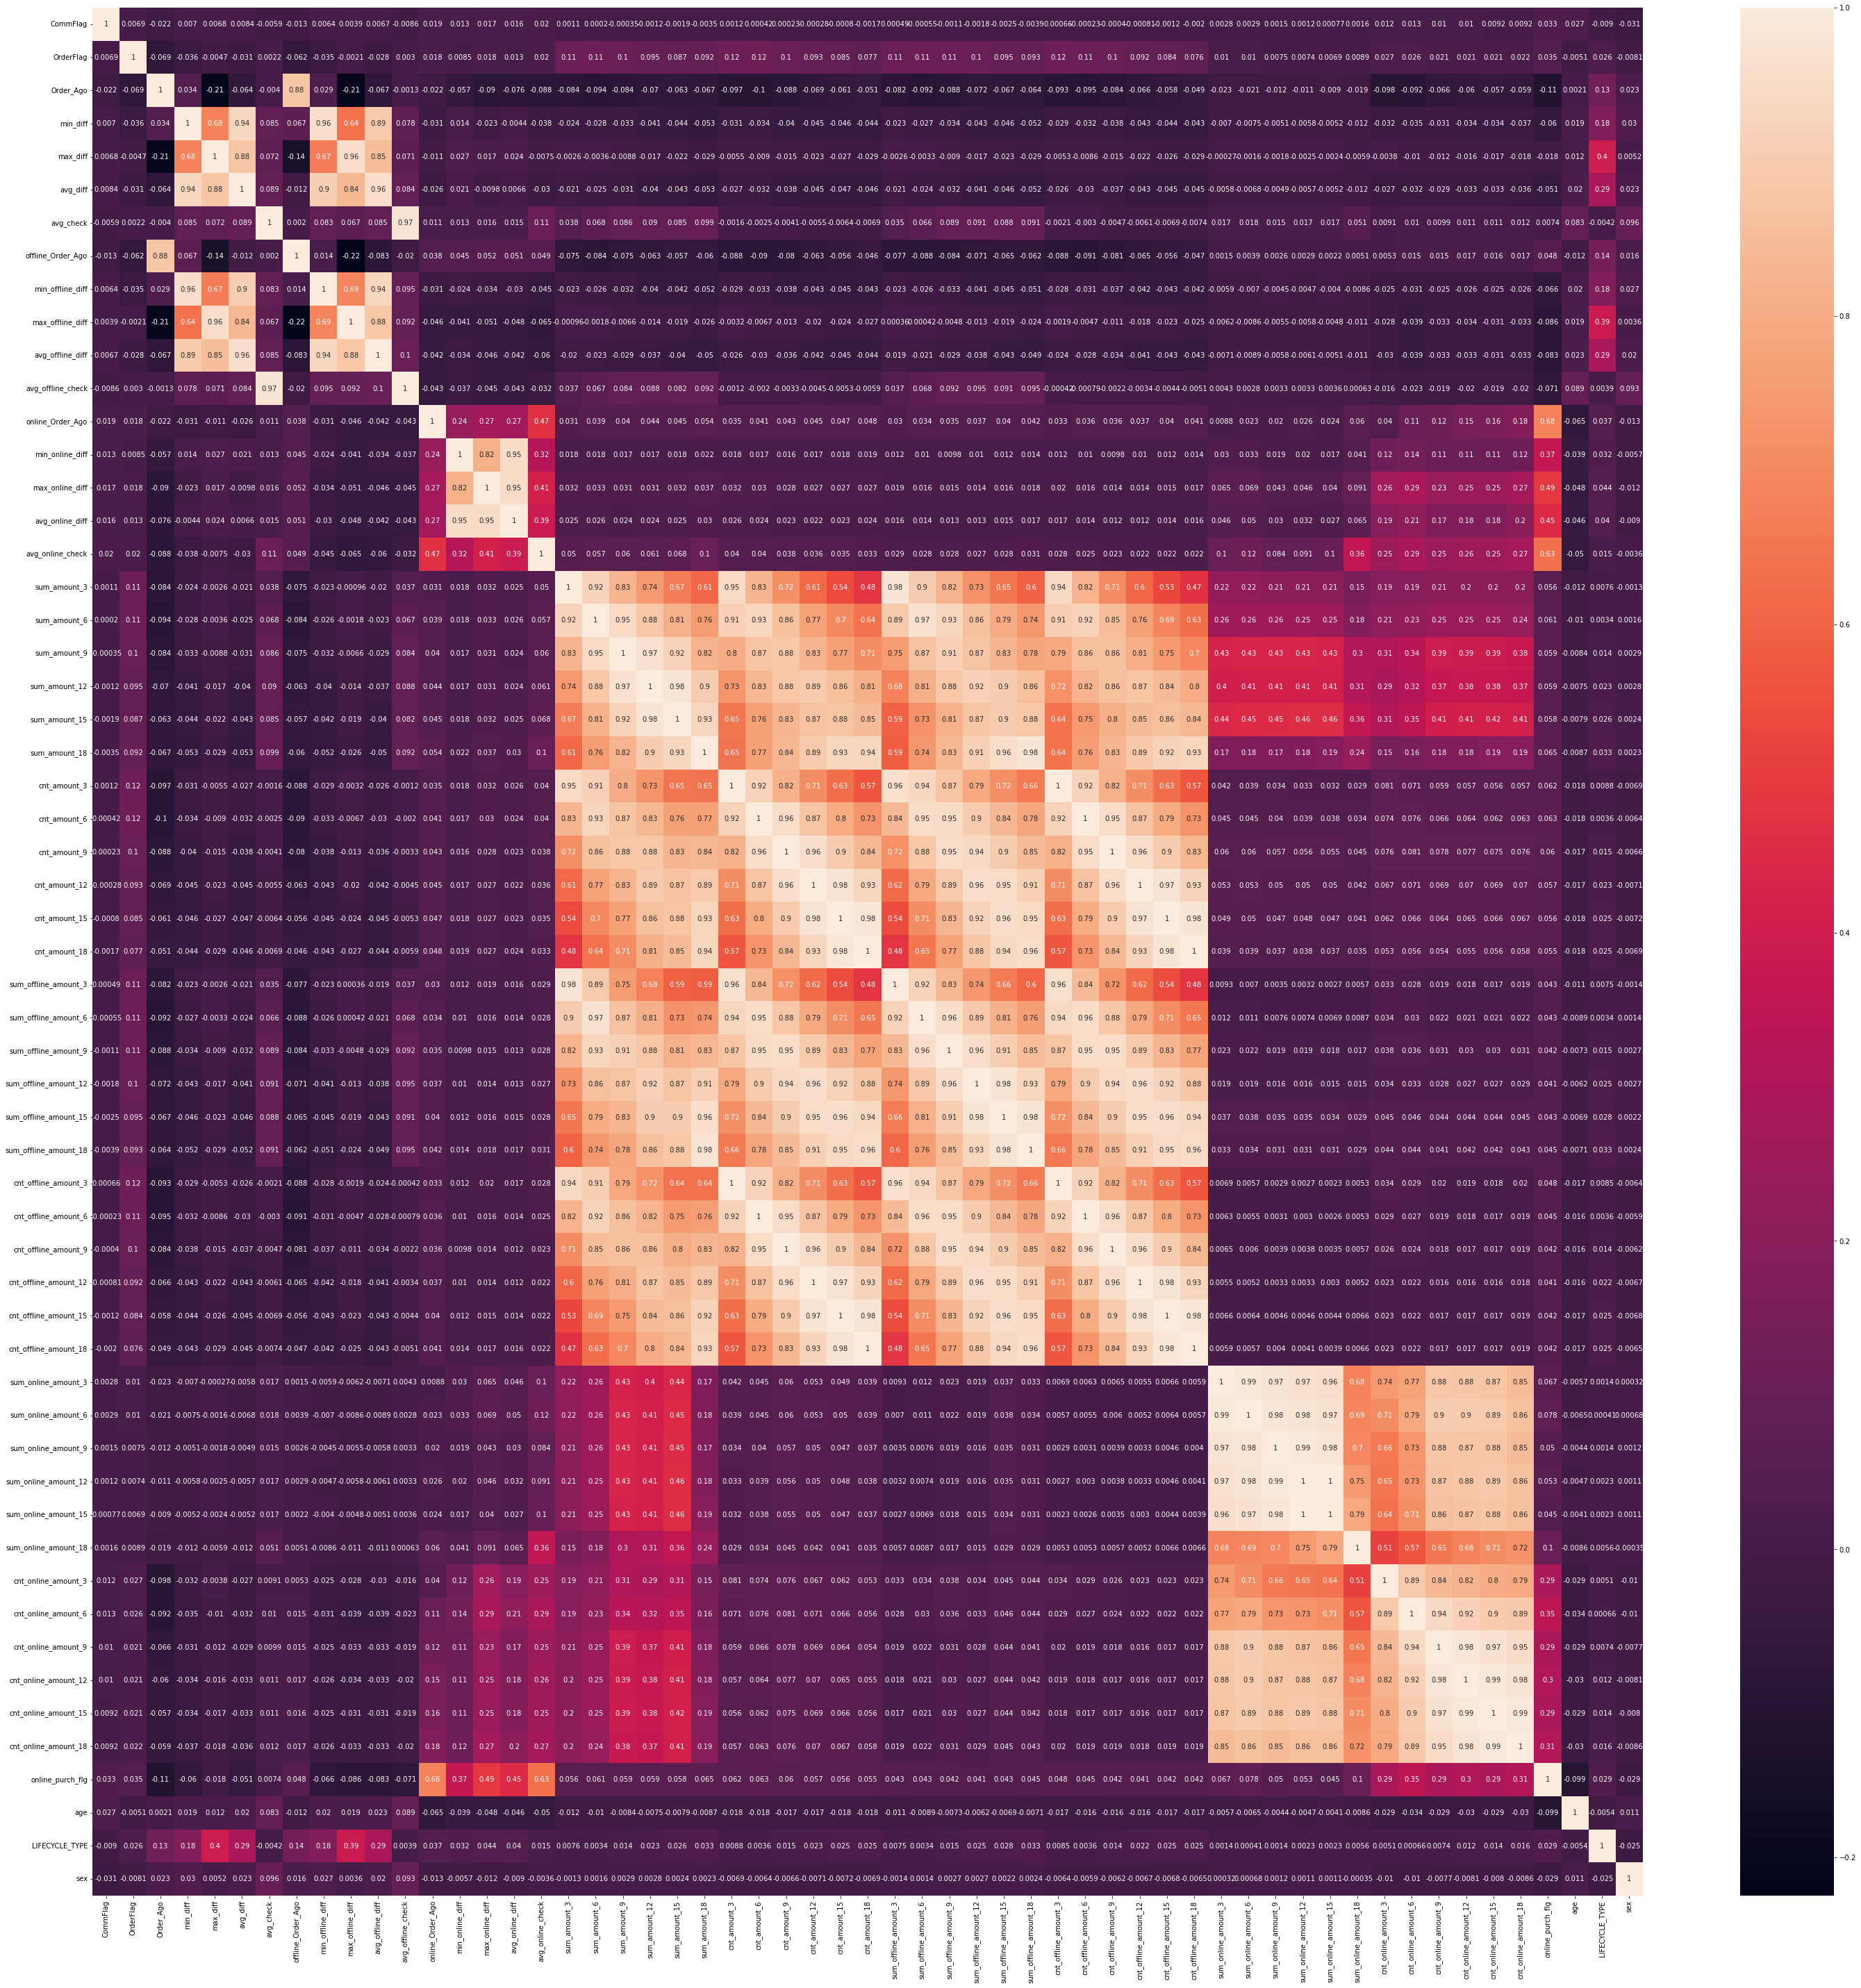

In [14]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (50, 50))
corr_matrix = df.corr()

#Using heatmap to visualize the correlation matrix
sns.heatmap(corr_matrix, annot=True, ax = ax)
del corr_matrix

In [15]:
df.iloc[:, 2:].head()

,Order_Ago,min_diff,max_diff,avg_diff,avg_check,offline_Order_Ago,min_offline_diff,max_offline_diff,avg_offline_diff,avg_offline_check,...,cnt_online_amount_3,cnt_online_amount_6,cnt_online_amount_9,cnt_online_amount_12,cnt_online_amount_15,cnt_online_amount_18,online_purch_flg,age,LIFECYCLE_TYPE,sex
phone,,,,,,,,,,,,,,,,,,,,,
70000136255,-0.125533,-0.611077,-1.265538,-0.950191,-0.083766,-1.342213,-0.624741,-1.278591,-0.968908,-0.990069,...,-0.088242,14.746600,8.695456,7.085026,5.938239,5.697424,3.308048,-1.517958,-3.211732,-0.343506
70501081555,-1.427658,-0.590035,-0.595441,-0.677813,1.046191,-1.342213,-0.587939,-0.569527,-0.664678,1.062153,...,-0.088242,-0.104858,-0.087572,-0.091512,-0.088777,-0.094621,-0.302293,-0.413218,0.311358,-0.343506
70501521555,-0.385958,-0.621598,0.729525,0.133763,1.152208,-0.396243,-0.619483,0.742995,0.142913,1.565652,...,-0.088242,1.545304,0.888320,0.705881,0.580892,0.548939,3.308048,-0.583178,0.311358,-0.343506
70501655539,-1.167233,-0.516388,-0.509140,-0.544403,-0.472315,-1.105721,-0.514334,-0.484037,-0.531924,-0.445221,...,-0.088242,-0.104858,-0.087572,-0.091512,-0.088777,-0.094621,-0.302293,-0.498198,0.311358,-0.343506
70501785797,-1.167233,-0.595295,-0.610670,-0.733400,0.642035,-1.105721,-0.593196,-0.584613,-0.719993,0.660959,...,-0.088242,-0.104858,-0.087572,-0.091512,-0.088777,-0.094621,-0.302293,0.096662,0.311358,-0.343506


In [16]:
y = df.iloc[:, 0:2]
p = round(y[y.CommFlag == 1].shape[0] / y.shape[0], 1) #0.5
Z = y.OrderFlag * (y.CommFlag - p) / (p * (1-p)) 
del y

gc.collect()
gc.enable()

features = df.iloc[:, 2:].columns.tolist()
X = df.iloc[:, 2:].replace(np.inf, 0).values




    

In [17]:
# for c in X.T:
#     if any(pd.isna(c)):
#         print('Ooops')


In [18]:
del df
gc.collect()

0

In [19]:
p

0.9

In [20]:
#X.head()

In [21]:
Z.describe()

count    3.147591e+06
mean     9.459439e-03
std      3.423001e-01
min     -1.000000e+01
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.111111e+00
dtype: float64

In [22]:
# imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
# scaler = StandardScaler()
# X = scaler.fit_transform(imp_mean.fit_transform(X))
# pd.isna(X).any()


In [23]:
# gc.collect()
# del X_test
# del X_train
# del y_test
# del y_train
# del automl

In [24]:
gc.collect()

0

## GridSearch

In [22]:

X_train,X_test,y_train,y_test=evalml.preprocessing.split_data(X, Z,problem_type='regression')

In [23]:
# for i, c in enumerate(X_train.T):
#     if pd.isna(c):
#         print(X_train.T[i])

In [24]:
del X
del Z


In [19]:
gc.collect()
gc.enable()

In [26]:


param_grid = {
    'bootstrap': [True],
    'max_depth': [2, 4, 6, 10, 20],
    
    'min_samples_leaf': [1, 2, 3, 4, 6],
    'min_samples_split': [2, 4, 8],
    'n_estimators': [100]
}# Create a based model
rf = RandomForestRegressor(verbose = 1, n_jobs = -1)# Instantiate the grid search model
grid_search = TuneSearchCV(estimator = rf, param_distributions= param_grid, 
                           n_jobs = 4, verbose = 2)

In [ ]:
grid_search.fit(X_train, y_train)

In [28]:
best = grid_search.best_estimator_

In [ ]:
grid_search.best_params_

Best properties:<br>
{ <br>  'bootstrap': True, <br>
    'max_depth': 6,<br>
    'min_samples_leaf': 4,<br>
    'min_samples_split': 4,<br>
    'n_estimators': 100<br>
 }

## Train with best properties:<br>
{ <br>  'bootstrap': True, <br>
    'max_depth': 6,<br>
    'min_samples_leaf': 4,<br>
    'min_samples_split': 4,<br>
    'n_estimators': 100<br>
 }

In [25]:

rf = RandomForestRegressor(bootstrap=True
                           , max_depth=6
                           ,min_samples_leaf=4
                           , min_samples_split= 4
                           , n_estimators= 100
                            , verbose = 1
                            , n_jobs = -1)# Instantiate the grid search model

In [26]:
rf.fit(X, Z)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 14.1min finished


RandomForestRegressor(max_depth=6, min_samples_leaf=4, min_samples_split=4,
                      n_jobs=-1, verbose=1)

In [27]:
est = rf.estimators_[5]

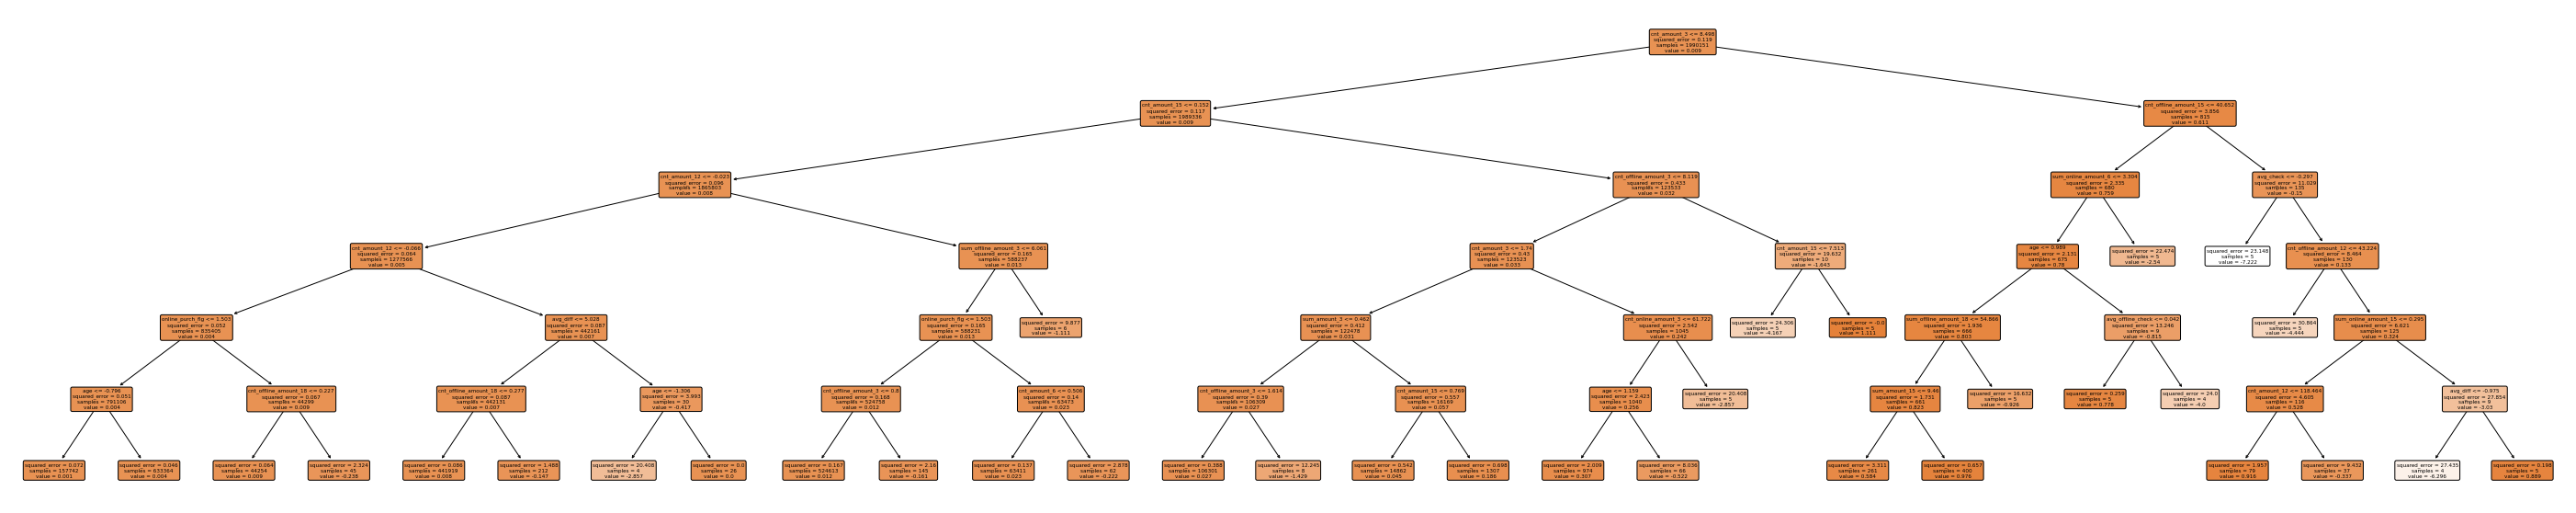

In [28]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import matplotlib as mpl


fig = plt.figure(figsize=(50, 10))
plot_tree(rf.estimators_[0], 
          feature_names=features
          
          ,filled=True, impurity=True, 
          rounded=True)
plt.savefig('tree.png', dpi = 500)


In [29]:
import joblib
filename = 'best_RandomForest.sav'
joblib.dump(rf, filename)

['best_RandomForest.sav']

In [30]:
for r in sorted(list(zip(features, rf.feature_importances_)), key = lambda x: -x[1]):
    print(f'{r[0]} : {r[1]:.2%}')

cnt_amount_3 : 12.90%
cnt_offline_amount_3 : 8.60%
cnt_amount_12 : 7.05%
age : 4.56%
sum_amount_3 : 3.45%
avg_check : 2.89%
avg_offline_check : 2.79%
sum_offline_amount_3 : 2.70%
cnt_offline_amount_6 : 2.69%
cnt_amount_18 : 2.56%
cnt_offline_amount_12 : 2.43%
cnt_amount_6 : 2.41%
online_Order_Ago : 2.35%
avg_diff : 2.30%
cnt_amount_15 : 2.13%
sum_online_amount_18 : 2.08%
sum_offline_amount_15 : 1.74%
cnt_offline_amount_15 : 1.59%
sum_amount_6 : 1.51%
avg_online_check : 1.50%
cnt_offline_amount_18 : 1.48%
sum_online_amount_12 : 1.47%
sum_offline_amount_9 : 1.44%
sum_online_amount_6 : 1.43%
max_diff : 1.40%
sum_amount_15 : 1.31%
cnt_offline_amount_9 : 1.23%
cnt_amount_9 : 1.22%
offline_Order_Ago : 1.17%
sum_amount_9 : 1.15%
sum_amount_12 : 1.13%
sum_amount_18 : 1.11%
sum_offline_amount_18 : 1.08%
sum_online_amount_3 : 1.03%
online_purch_flg : 1.03%
sum_offline_amount_6 : 1.01%
sum_online_amount_9 : 0.97%
avg_offline_diff : 0.96%
max_online_diff : 0.92%
sum_offline_amount_12 : 0.90%
max_o

# Submition

In [3]:
from sklift.metrics import uplift_at_k
import joblib

In [4]:
filename = 'best_RandomForest.sav'
loaded_model = joblib.load(filename)


In [5]:
#Submission
subm = pd.read_csv('ControlSet.zip', sep = ';',dtype={'phone':'str', 'Order_Ago':'float64'})
subm = subm.set_index('phone')
subm.head()

,CommFlag,OrderFlag,Order_Ago,min_diff,max_diff,avg_diff,avg_check,offline_Order_Ago,min_offline_diff,max_offline_diff,...,cnt_online_amount_3,cnt_online_amount_6,cnt_online_amount_9,cnt_online_amount_12,cnt_online_amount_15,cnt_online_amount_18,online_purch_flg,age,LIFECYCLE_TYPE,sex
phone,,,,,,,,,,,,,,,,,,,,,
70000020494,0,1,1.0,4.0,256.0,49.0,3402.4222,1.0,4.0,23.0,...,8,9,10,10,10,13,True,NaN,1,0.0
70000068068,0,0,10.0,NaN,NaN,NaN,1844.0000,NaN,NaN,NaN,...,0,0,0,1,1,1,True,47.0,1,0.0
70000069087,0,0,4.0,8.0,82.0,48.0,9827.7000,4.0,8.0,109.0,...,0,0,0,1,1,1,True,35.0,1,0.0
70000103922,0,0,1.0,1.0,98.0,27.0,3437.3096,3.0,1.0,98.0,...,1,1,1,1,1,1,True,33.0,1,0.0
70000146945,0,0,5.0,1.0,171.0,44.0,4742.9785,5.0,36.0,171.0,...,0,0,0,0,0,9,True,21.0,1,0.0


In [6]:
for r in sorted(list(zip(subm.iloc[:, 2:].columns.to_list(), loaded_model.feature_importances_)), key = lambda x: -x[1]):
    print(f'{r[0]} : {r[1]:.2%}')

cnt_amount_3 : 12.90%
cnt_offline_amount_3 : 8.60%
cnt_amount_12 : 7.05%
age : 4.56%
sum_amount_3 : 3.45%
avg_check : 2.89%
avg_offline_check : 2.79%
sum_offline_amount_3 : 2.70%
cnt_offline_amount_6 : 2.69%
cnt_amount_18 : 2.56%
cnt_offline_amount_12 : 2.43%
cnt_amount_6 : 2.41%
online_Order_Ago : 2.35%
avg_diff : 2.30%
cnt_amount_15 : 2.13%
sum_online_amount_18 : 2.08%
sum_offline_amount_15 : 1.74%
cnt_offline_amount_15 : 1.59%
sum_amount_6 : 1.51%
avg_online_check : 1.50%
cnt_offline_amount_18 : 1.48%
sum_online_amount_12 : 1.47%
sum_offline_amount_9 : 1.44%
sum_online_amount_6 : 1.43%
max_diff : 1.40%
sum_amount_15 : 1.31%
cnt_offline_amount_9 : 1.23%
cnt_amount_9 : 1.22%
offline_Order_Ago : 1.17%
sum_amount_9 : 1.15%
sum_amount_12 : 1.13%
sum_amount_18 : 1.11%
sum_offline_amount_18 : 1.08%
sum_online_amount_3 : 1.03%
online_purch_flg : 1.03%
sum_offline_amount_6 : 1.01%
sum_online_amount_9 : 0.97%
avg_offline_diff : 0.96%
max_online_diff : 0.92%
sum_offline_amount_12 : 0.90%
max_o

In [7]:
subm = preproc_data(subm)

m = np.load('means.npy')
sig = np.load('std.npy')
subm.iloc[:, 2:] = (subm.iloc[:, 2:] - m) / (sig + 1e-12)

subm.head()


,CommFlag,OrderFlag,Order_Ago,min_diff,max_diff,avg_diff,avg_check,offline_Order_Ago,min_offline_diff,max_offline_diff,...,cnt_online_amount_3,cnt_online_amount_6,cnt_online_amount_9,cnt_online_amount_12,cnt_online_amount_15,cnt_online_amount_18,online_purch_flg,age,LIFECYCLE_TYPE,sex
phone,,,,,,,,,,,,,,,,,,,,,
70000020494,0,1,-1.167233,-0.605816,-0.011644,-0.711165,0.187925,-1.105721,-0.603711,-1.162928,...,22.910980,14.746600,9.671348,7.882419,6.607908,8.271666,3.308048,-0.583178,0.311358,-0.343506
70000068068,0,0,1.176592,-0.626858,-1.311227,-0.983543,-0.365889,-1.342213,-0.624741,-1.278591,...,-0.088242,-0.104858,-0.087572,0.705881,0.580892,0.548939,3.308048,0.436581,0.311358,-0.343506
70000069087,0,0,-0.385958,-0.584774,-0.894954,-0.716724,2.471262,-0.396243,-0.582681,-0.730449,...,-0.088242,-0.104858,-0.087572,0.705881,0.580892,0.548939,3.308048,-0.583178,0.311358,-0.343506
70000103922,0,0,-1.167233,-0.621598,-0.813730,-0.833457,0.200322,-0.632736,-0.619483,-0.785766,...,2.786661,1.545304,0.888320,0.705881,0.580892,0.548939,3.308048,-0.753138,0.311358,-0.343506
70000146945,0,0,-0.125533,-0.621598,-0.443146,-0.738959,0.664315,-0.159751,-0.435473,-0.418662,...,-0.088242,-0.104858,-0.087572,-0.091512,-0.088777,5.697424,3.308048,-1.772898,0.311358,-0.343506


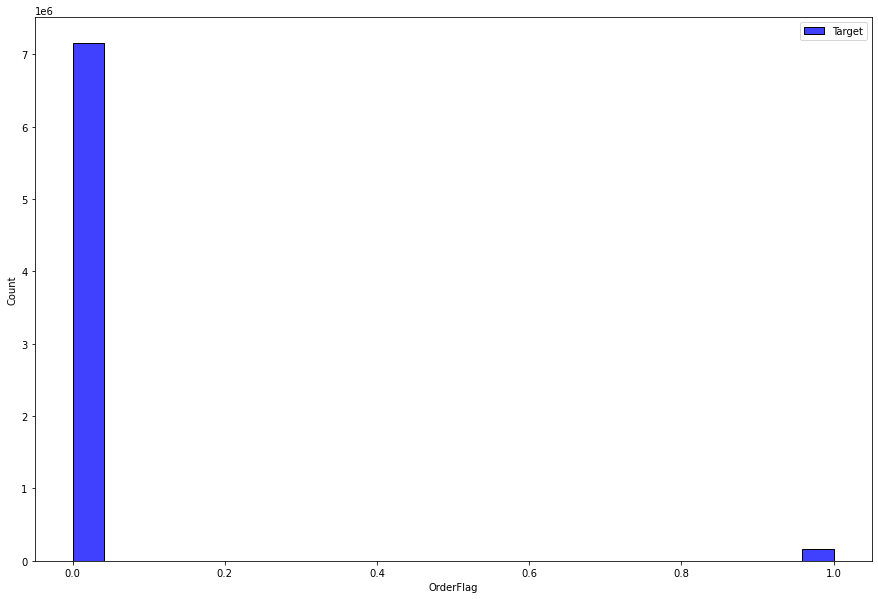

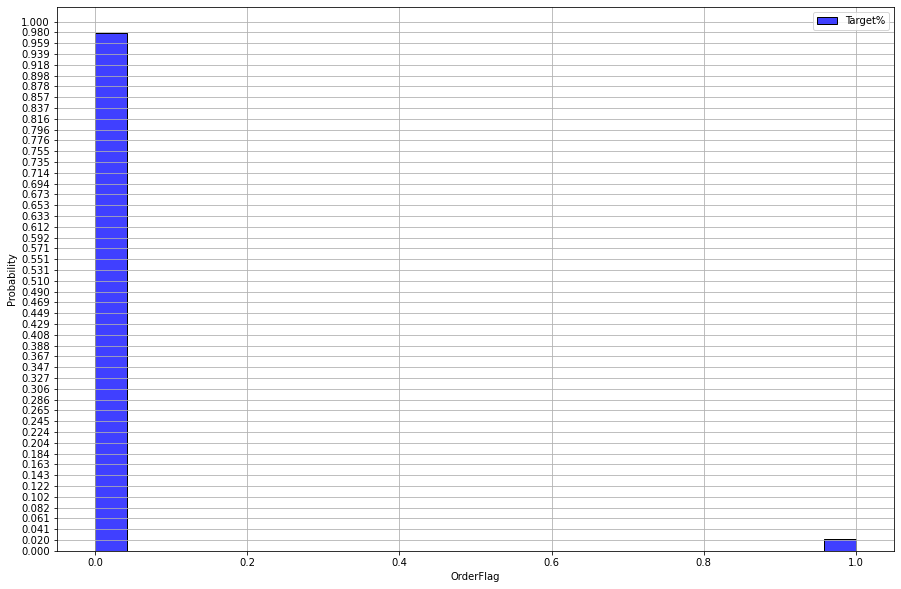

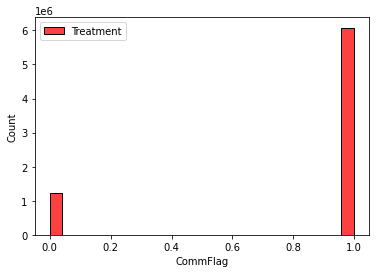

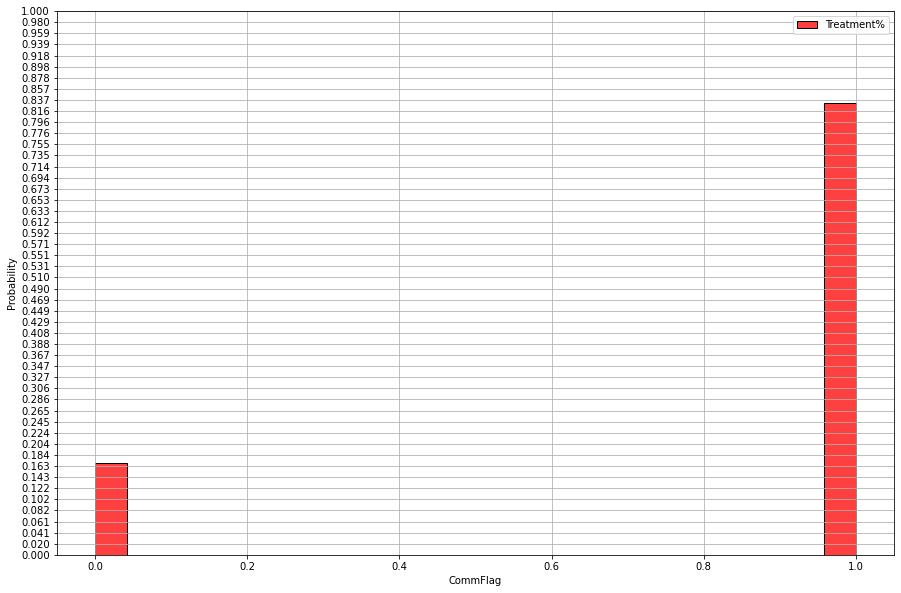

In [8]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (15, 10))
sns.histplot(subm.OrderFlag, label = 'Target', color = 'blue')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize = (15, 10))
sns.histplot(subm.OrderFlag, label = 'Target%', color = 'blue', stat = 'probability')
ax.set_yticks(np.linspace(0, 1, 50))
ax.grid('both')
plt.legend()
plt.show()

sns.histplot(subm.CommFlag, label = 'Treatment', color = 'red')
plt.legend()
plt.show()


fig, ax = plt.subplots(figsize = (15, 10))
sns.histplot(subm.CommFlag, label = 'Treatment%', color = 'red', stat = 'probability')
ax.set_yticks(np.linspace(0, 1, 50))
ax.grid('both')
plt.legend()
plt.show()

In [9]:
X_ = subm.iloc[:, 2:].values
X_val = subm.iloc[:, 2:]
Y_val = subm.iloc[:, [0, 1]]

In [10]:
del subm
gc.collect()

17162

In [11]:
Y_val.head()

,CommFlag,OrderFlag
phone,,
70000020494,0,1
70000068068,0,0
70000069087,0,0
70000103922,0,0
70000146945,0,0


In [12]:
Y_val_subm = Y_val[(Y_val['CommFlag'] == 1) & (Y_val['OrderFlag'] == 1)]
Y_val[(Y_val['CommFlag'] == 1) & (Y_val['OrderFlag'] == 1)].shape[0]

135500

In [13]:

y_pred_1 = loaded_model.predict(X_)
y_pred_1

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.7s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    6.5s finished


array([0.07853987, 0.00633192, 0.02667493, ..., 0.00495966, 0.0080454 ,
       0.00525897])

In [14]:
y_pred_1.shape

(7310018,)

<AxesSubplot:ylabel='Count'>

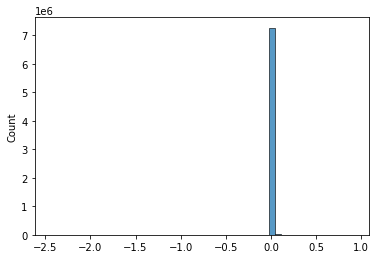

In [17]:
sns.histplot(y_pred_1, bins = 50)

In [18]:
X_val['UpLift'] = y_pred_1.tolist()
X_val['UpLift'].describe()

count    7.310018e+06
mean     9.735291e-03
std      2.444958e-02
min     -2.449332e+00
25%      3.624369e-03
50%      7.462217e-03
75%      1.031229e-02
max      9.215436e-01
Name: UpLift, dtype: float64

In [19]:
X_val.head()

,Order_Ago,min_diff,max_diff,avg_diff,avg_check,offline_Order_Ago,min_offline_diff,max_offline_diff,avg_offline_diff,avg_offline_check,...,cnt_online_amount_6,cnt_online_amount_9,cnt_online_amount_12,cnt_online_amount_15,cnt_online_amount_18,online_purch_flg,age,LIFECYCLE_TYPE,sex,UpLift
phone,,,,,,,,,,,,,,,,,,,,,
70000020494,-1.167233,-0.605816,-0.011644,-0.711165,0.187925,-1.105721,-0.603711,-1.162928,-0.902531,-0.760801,...,14.746600,9.671348,7.882419,6.607908,8.271666,3.308048,-0.583178,0.311358,-0.343506,0.078540
70000068068,1.176592,-0.626858,-1.311227,-0.983543,-0.365889,-1.342213,-0.624741,-1.278591,-0.968908,-0.990069,...,-0.104858,-0.087572,0.705881,0.580892,0.548939,3.308048,0.436581,0.311358,-0.343506,0.006332
70000069087,-0.385958,-0.584774,-0.894954,-0.716724,2.471262,-0.396243,-0.582681,-0.730449,-0.637021,2.910229,...,-0.104858,-0.087572,0.705881,0.580892,0.548939,3.308048,-0.583178,0.311358,-0.343506,0.026675
70000103922,-1.167233,-0.621598,-0.813730,-0.833457,0.200322,-0.632736,-0.619483,-0.785766,-0.830622,0.243412,...,1.545304,0.888320,0.705881,0.580892,0.548939,3.308048,-0.753138,0.311358,-0.343506,0.076085
70000146945,-0.125533,-0.621598,-0.443146,-0.738959,0.664315,-0.159751,-0.435473,-0.418662,-0.465546,1.440565,...,-0.104858,-0.087572,-0.091512,-0.088777,5.697424,3.308048,-1.772898,0.311358,-0.343506,0.010178


In [20]:
print(X_.shape)
print(X_val.shape)

(7310018, 55)
(7310018, 56)


In [21]:
X_val_metric = X_val.merge(Y_val, on = 'phone')
print(X_val_metric.shape)
X_val_metric.head()


(7310018, 58)


,Order_Ago,min_diff,max_diff,avg_diff,avg_check,offline_Order_Ago,min_offline_diff,max_offline_diff,avg_offline_diff,avg_offline_check,...,cnt_online_amount_12,cnt_online_amount_15,cnt_online_amount_18,online_purch_flg,age,LIFECYCLE_TYPE,sex,UpLift,CommFlag,OrderFlag
phone,,,,,,,,,,,,,,,,,,,,,
70000020494,-1.167233,-0.605816,-0.011644,-0.711165,0.187925,-1.105721,-0.603711,-1.162928,-0.902531,-0.760801,...,7.882419,6.607908,8.271666,3.308048,-0.583178,0.311358,-0.343506,0.078540,0,1
70000068068,1.176592,-0.626858,-1.311227,-0.983543,-0.365889,-1.342213,-0.624741,-1.278591,-0.968908,-0.990069,...,0.705881,0.580892,0.548939,3.308048,0.436581,0.311358,-0.343506,0.006332,0,0
70000069087,-0.385958,-0.584774,-0.894954,-0.716724,2.471262,-0.396243,-0.582681,-0.730449,-0.637021,2.910229,...,0.705881,0.580892,0.548939,3.308048,-0.583178,0.311358,-0.343506,0.026675,0,0
70000103922,-1.167233,-0.621598,-0.813730,-0.833457,0.200322,-0.632736,-0.619483,-0.785766,-0.830622,0.243412,...,0.705881,0.580892,0.548939,3.308048,-0.753138,0.311358,-0.343506,0.076085,0,0
70000146945,-0.125533,-0.621598,-0.443146,-0.738959,0.664315,-0.159751,-0.435473,-0.418662,-0.465546,1.440565,...,-0.091512,-0.088777,5.697424,3.308048,-1.772898,0.311358,-0.343506,0.010178,0,0


In [22]:
any(X_val_metric.OrderFlag.isna())

False

In [23]:
X_val_metric.CommFlag.values.min()

0

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


array([<AxesSubplot:title={'center':'Uplift by percentile\nweighted average uplift = 0.0045'}>,
       <AxesSubplot:title={'center':'Response rate by percentile'}, xlabel='Percentile'>],
      dtype=object)

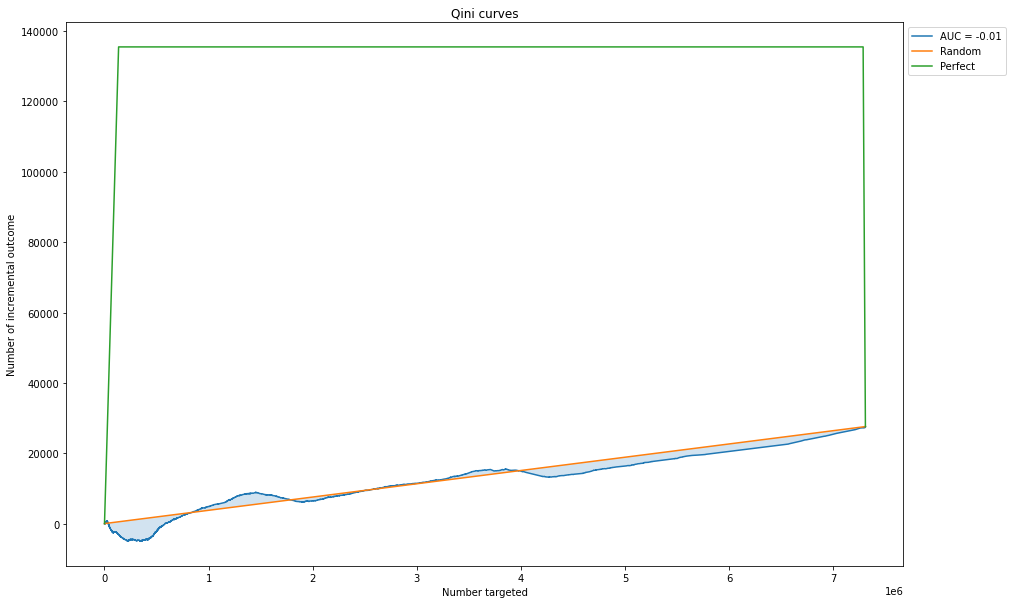

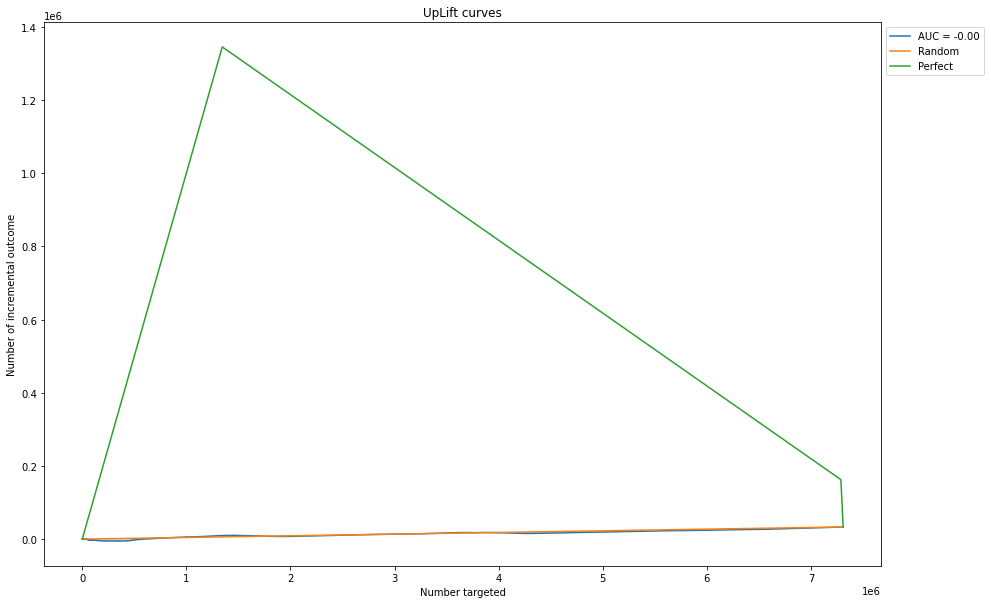

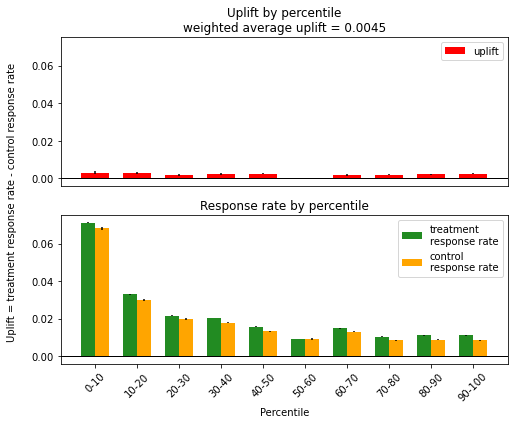

In [24]:
from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (15,10))
ax.set_title('Qini curves')

plot_qini_curve(y_true = X_val_metric.OrderFlag.values
                , uplift = X_val_metric.UpLift.values
                , treatment = X_val_metric.CommFlag.values
                , perfect = True, ax = ax)


fig, ax = plt.subplots(figsize = (15,10))
ax.set_title('UpLift curves')
plot_uplift_curve(y_true = X_val_metric.OrderFlag.values
                , uplift = X_val_metric.UpLift.values
                , treatment = X_val_metric.CommFlag.values
                , perfect = True, ax = ax)



plot_uplift_by_percentile(y_true = X_val_metric.OrderFlag.values
                , uplift = X_val_metric.UpLift.values 
                , treatment = X_val_metric.CommFlag.values, kind = 'bar')


In [25]:
h = 0.1
T = int(1 / h)
s = 0.01
cr = []
ac = []
part = []
X_val = X_val.sort_values('UpLift', ascending= False)
for i in range(0, T + 1):
    X_val_subm_i = X_val.iloc[0: round(X_val.shape[0] * s), :].merge(Y_val[Y_val['CommFlag'] == 1], on = 'phone', suffixes=('', '_y'))
    X_val_subm_i = X_val_subm_i.merge(Y_val_subm, how='left', on = 'phone', suffixes=('', '_y'))
    cr.append(X_val_subm_i[X_val_subm_i.OrderFlag == 1].shape[0] / X_val_subm_i.shape[0])
    ac.append(X_val_subm_i[X_val_subm_i.OrderFlag == 1].shape[0] / Y_val_subm.shape[0])
    part.append(s)
    del X_val_subm_i
    gc.collect()
    s += h

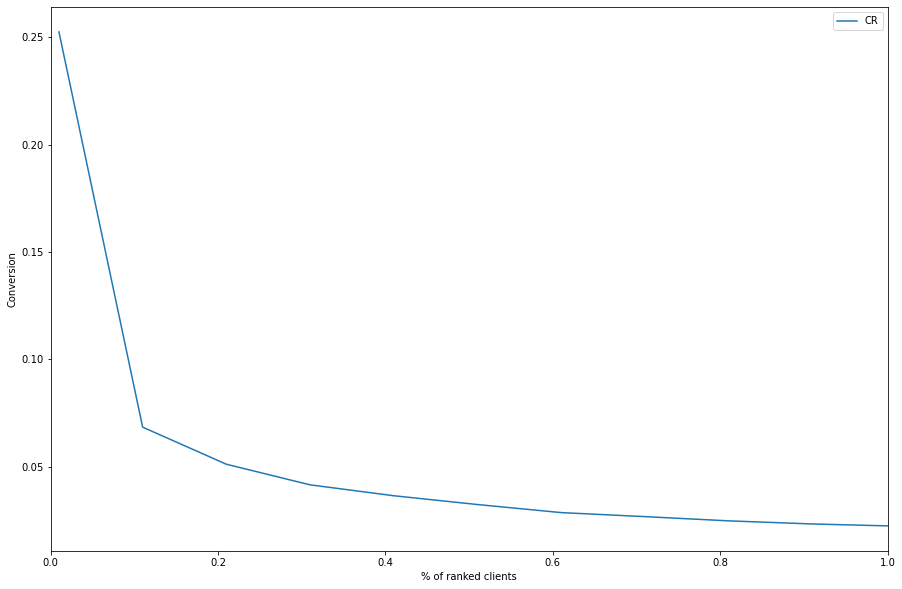

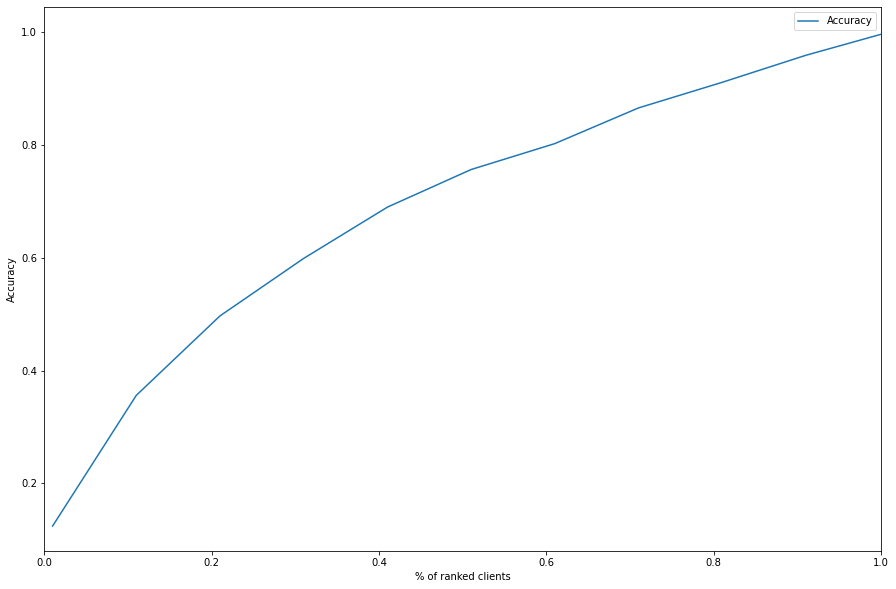

In [26]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (15, 10))
plt.plot(part, cr, label = 'CR')
plt.legend()
plt.xlabel('% of ranked clients')
plt.ylabel('Conversion')

plt.xlim(0, 1)
plt.show()

%matplotlib inline
fig, ax = plt.subplots(figsize = (15, 10))
plt.plot(part, ac, label = 'Accuracy')

plt.xlim(0, 1)
plt.xlabel('% of ranked clients')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [27]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.DataFrame({'Part':part, 'CR':cr, 'ACC':ac})


,Part,CR,ACC
0,0.01,0.252541,0.124509
1,0.11,0.068389,0.356066
2,0.21,0.051114,0.496878
3,0.31,0.041512,0.598716
4,0.41,0.036428,0.689550
5,0.51,0.032334,0.756162
6,0.61,0.028579,0.802111
7,0.71,0.026703,0.865314
8,0.81,0.024733,0.910708
9,0.91,0.023282,0.958583


<p style = "font-color:blue;">
Part	CR	ACC <br>
0.10	0.115568	0.317885<br>
0.15	0.098023	0.404434<br>
0.20	0.087061	0.478943<br>
0.25	0.079196	0.544595<br>
0.30	0.072784	0.600603<br>
0.35	0.067779	0.652520<br>
0.40	0.063647	0.700270<br>
0.45	0.060014	0.742842<br>
0.50	0.056950	0.783243<br>
0.55	0.054026	0.817332<br>
0.60	0.051604	0.851656<br>
0.65	0.049165	0.879014<br>
0.70	0.047004	0.905033<br>
0.75	0.044985	0.928019<br>
0.80	0.043039	0.947082<br>
0.85	0.041261	0.964702<br>
0.90	0.039611	0.980591<br>
0.95	0.037957	0.991854<br>
1.00	0.036355	1.000000<br>
1.05	0.036355	1.000000<br>
</p>

In [73]:
Y_val[Y_val['CommFlag'] == 1].shape[0]

3306567

In [58]:
 X_val.sort_values('UpLift', ascending= False).iloc[0: round(X_val.shape[0] * s), :].merge(Y_val[Y_val['CommFlag'] == 1], on = 'phone', suffixes=('', '_y')).shape

(506975, 43)

In [30]:
X_val_subm.head()

,Order_Ago,min_diff,max_diff,avg_diff,avg_check,avg_mass_check,Mean_Item_Cost,sum_amount_18,cnt_amount_18,Mass_amount_18,...,Lux_Parfume_Amount_9,Lux_Parfume_Amount_12,Lux_Parfume_Amount_15,age,LIFECYCLE_TYPE,sex,CommFlag_x,OrderFlag_x,CommFlag_y,OrderFlag_y
phone,,,,,,,,,,,,,,,,,,,,,
79000000911,2.0,0.0,0.0,0.0,5471.0000,5471.00,5471.000000,5471.00,1,5471.00,...,0.0,0.0,0.0,NaN,0,1.0,NaN,NaN,NaN,NaN
79000001507,3.0,0.0,0.0,0.0,893.0000,893.00,893.000000,893.00,1,893.00,...,0.0,0.0,0.0,41.0,1,0.0,NaN,NaN,NaN,NaN
79000002803,12.0,43.0,43.0,43.0,4073.0833,4069.75,6109.625000,12219.25,3,12209.25,...,0.0,0.0,0.0,30.0,1,1.0,NaN,NaN,NaN,NaN
79000002888,4.0,0.0,0.0,0.0,5233.0000,5233.00,2616.500000,5233.00,1,5233.00,...,0.0,0.0,0.0,NaN,1,0.0,NaN,NaN,NaN,NaN
79000003036,6.0,137.0,137.0,137.0,2909.0000,2905.50,646.444444,5818.00,2,5811.00,...,0.0,0.0,0.0,39.0,1,1.0,NaN,NaN,NaN,NaN


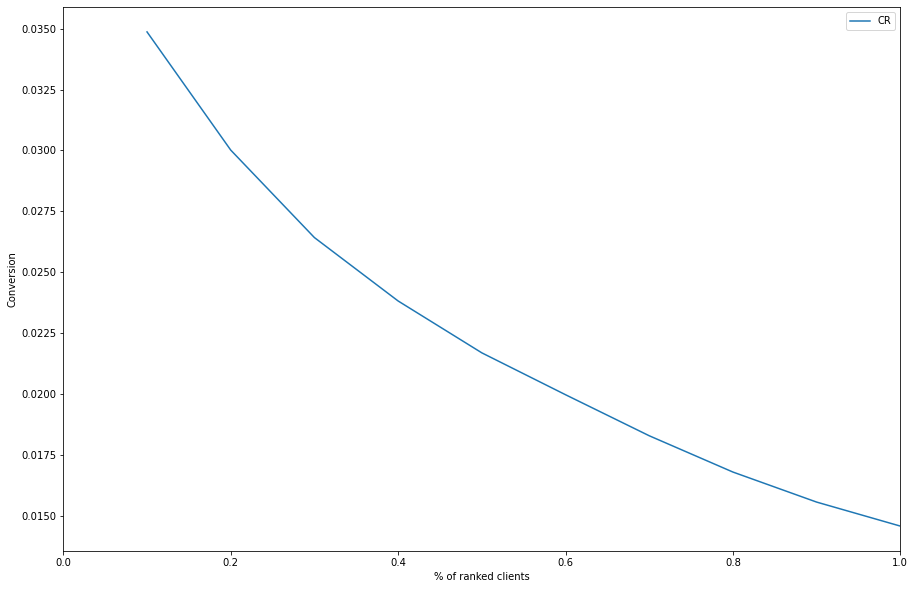

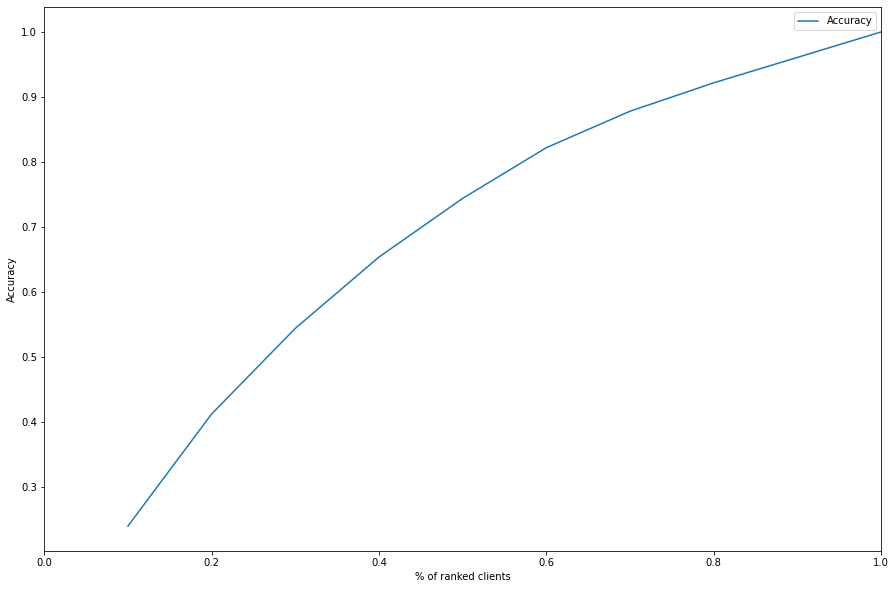

In [51]:
h = 0.1
s = 0.1
cr = []
ac = []
part = []
for i in range(0, 10):
    X_val_subm_i = X_val.sort_values('UpLift', ascending= False).iloc[0: round(X_val.shape[0] * s), :]
    X_val_subm_i = X_val_subm_i.merge(Y_val_subm, how='left', on = 'phone', suffixes=('', '_y'))
    cr.append(X_val_subm_i[X_val_subm_i.OrderFlag == 1].shape[0] / X_val_subm_i.shape[0])
    ac.append(X_val_subm_i[X_val_subm_i.OrderFlag == 1].shape[0] / Y_val_subm.shape[0])
    part.append(s)
    del X_val_subm_i
    gc.collect()
    s += h
    
    
%matplotlib inline
fig, ax = plt.subplots(figsize = (15, 10))
plt.plot(part, cr, label = 'CR')
plt.legend()
plt.xlabel('% of ranked clients')
plt.ylabel('Conversion')

plt.xlim(0, 1)
plt.show()

%matplotlib inline
fig, ax = plt.subplots(figsize = (15, 10))
plt.plot(part, ac, label = 'Accuracy')

plt.xlim(0, 1)
plt.xlabel('% of ranked clients')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [53]:
pd.DataFrame({'CR':cr, 'Part':part})

,CR,Part
0,0.136361,0.1
1,0.097872,0.2
2,0.078931,0.3
3,0.068516,0.4
4,0.060734,0.5
5,0.054218,0.6
6,0.048734,0.7
7,0.043914,0.8
8,0.039896,0.9
9,0.036616,1.0


In [79]:
del subm
del X_val
del Y_val
del X_val_subm
del Y_val_subm

NameError: name 'subm' is not defined

In [80]:
gc.collect()

8337

# Load Submission

In [3]:
with pyodbc.connect('DRIVER={SQL SERVER};SERVER=SAS-CI-DB1-P;') as conn:
    strq = 'SELECT DISTINCT phone\
                    , CommFlag\
                    , OrderFlag\
                    ,Order_Ago\
                    ,min_diff\
                   , max_diff\
                    ,avg_diff\
                    ,avg_check\
                    ,offline_Order_Ago\
                    ,min_offline_diff\
                    ,max_offline_diff\
                    ,avg_offline_diff\
                    ,avg_offline_check\
                    ,online_Order_Ago\
                    ,min_online_diff\
                    ,max_online_diff\
                    ,avg_online_diff\
                    ,avg_online_check\
                    ,sum_amount_3\
                    ,sum_amount_6\
                    ,sum_amount_9\
                    ,sum_amount_12\
                    ,sum_amount_15\
                    ,sum_amount_18\
                    ,cnt_amount_3\
                    ,cnt_amount_6\
                    ,cnt_amount_9\
                    ,cnt_amount_12\
                    ,cnt_amount_15\
                    ,cnt_amount_18\
                    ,sum_offline_amount_3\
                    ,sum_offline_amount_6\
                    ,sum_offline_amount_9\
                    ,sum_offline_amount_12\
                    ,sum_offline_amount_15\
                    ,sum_offline_amount_18\
                    ,cnt_offline_amount_3\
                    ,cnt_offline_amount_6\
                    ,cnt_offline_amount_9\
                    ,cnt_offline_amount_12\
                    ,cnt_offline_amount_15\
                    ,cnt_offline_amount_18\
                    ,sum_online_amount_3\
                    ,sum_online_amount_6\
                    ,sum_online_amount_9\
                    ,sum_online_amount_12\
                    ,sum_online_amount_15\
                    ,sum_online_amount_18\
                    ,cnt_online_amount_3\
                    ,cnt_online_amount_6\
                    ,cnt_online_amount_9\
                    ,cnt_online_amount_12\
                    ,cnt_online_amount_15\
                    ,cnt_online_amount_18\
                    ,online_purch_flg\
                    , age\
                    , LIFECYCLE_TYPE\
                    , sex \
                    FROM ##DataSubm\
                    WHERE cnt_amount_18 > 0'
    df = pd.read_sql(strq, conn)

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


In [4]:
df.head()

,phone,CommFlag,OrderFlag,Order_Ago,min_diff,max_diff,avg_diff,avg_check,offline_Order_Ago,min_offline_diff,...,cnt_online_amount_3,cnt_online_amount_6,cnt_online_amount_9,cnt_online_amount_12,cnt_online_amount_15,cnt_online_amount_18,online_purch_flg,age,LIFECYCLE_TYPE,sex
0,70000136255,1,0,5,3.0,9.0,6.0,2637.8888,NaN,NaN,...,0,9,9,9,9,9,True,24.0,0,0.0
1,70501081555,1,0,0,7.0,141.0,55.0,5817.5720,0.0,7.0,...,0,0,0,0,0,0,False,37.0,1,0.0
2,70501521555,1,0,4,1.0,402.0,201.0,6115.9000,4.0,1.0,...,0,1,1,1,1,1,True,35.0,1,0.0
3,70501655539,1,0,1,21.0,158.0,79.0,1544.5166,1.0,21.0,...,0,0,0,0,0,0,False,36.0,1,0.0
4,70501785797,1,0,1,6.0,138.0,45.0,4680.2807,1.0,6.0,...,0,0,0,0,0,0,False,43.0,1,0.0


In [5]:
df[df.Order_Ago.isna()]

,phone,CommFlag,OrderFlag,Order_Ago,min_diff,max_diff,avg_diff,avg_check,offline_Order_Ago,min_offline_diff,...,cnt_online_amount_3,cnt_online_amount_6,cnt_online_amount_9,cnt_online_amount_12,cnt_online_amount_15,cnt_online_amount_18,online_purch_flg,age,LIFECYCLE_TYPE,sex


In [6]:
df.to_csv('ControlSet.csv', index = False, sep = ';')

In [7]:
del df

In [8]:
gc.collect()

0